In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy import stats
import math
import seaborn as sns
import time

In [2]:
# bootstrap to compute sem of the median
# 参考(https://qiita.com/katsu1110/items/23b8a37ac400dd0eaad2)

# x dim: 0/ #of samples, 1/ #of data dims
def bootstrap(x, n_add_samples, n_repeat=1000):
    
    if n_add_samples < n_repeat:
        print("[n_added_samples] must be larger than [n_repeat]...")
        return x
    
    ndim = np.shape(x)[1]
    increased_x = x
    
    for i in range(n_repeat):
        n_add = np.min([n_add_samples // n_repeat,  n_add_samples - i * (n_add_samples // n_repeat)])
        re = np.random.choice(len(x), len(x), replace=True)
        re_x = x[re, :]
        
        mean = np.mean(re_x, 0)
        cov = np.cov(re_x.T)
        
        increased_x = np.vstack([increased_x, np.random.multivariate_normal(mean, cov, n_add)])
        
    return increased_x


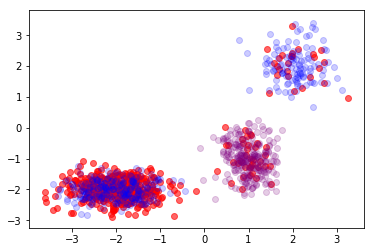

In [3]:
def build_toy_dataset(N, pi):
#   pi = np.array([0.1, 0.9])
  mus = [[2, 2], [-2, -2], [1, -1]]
  stds = [[0.2, 0.3], [0.3, 0.1], [0.1, 0.3]]
  x = np.zeros((N, 2), dtype=np.float32)
  for n in range(N):
    k = np.argmax(np.random.multinomial(1, pi))
    x[n, :] = np.random.multivariate_normal(mus[k], np.diag(stds[k]))
 
  return x
 
N = 500  # number of data points
ndim = 2  # dimensionality of data
a_rate = 0.3  # Rate of anomaly

x_train_n = build_toy_dataset(round(N*(1-a_rate)), np.array([0.3, 0.7, 0]))
x_train_a = build_toy_dataset(round(N*a_rate), np.array([0, 0, 1.0]))
x_train_a = bootstrap(x_train_a, round(N*a_rate), 100)
x_test = build_toy_dataset(N, np.array([0.05, 0.9, 0.05]))

x_train = np.vstack([x_train_n, x_train_a])
y_train = np.vstack([np.ones((len(x_train_n), 1)), np.zeros((len(x_train_a), 1))]).reshape(-1, 1)

plt.scatter(x_test[:, 0], x_test[:, 1], color="red", alpha=0.6)
plt.scatter(x_train_n[:, 0], x_train_n[:, 1], color="blue", alpha=0.2)
plt.scatter(x_train_a[:, 0], x_train_a[:, 1], color="purple", alpha=0.2)

plt.show()

In [4]:
# パラメータの初期化
a_rate = 0.1  # 誤報率
# k =  round(N * (1-a_rate)) # 近傍数
# k_r = 1-a_rate
k_r = 1-0.98
eta = 0.1  # ステップ幅
mu = 0.5  # 同一ラベルの密集度合と条件が破られている度合の早退的な重み（通常0.5）
n_train = len(x_train)

A = np.eye(2)

# # Forループによる算出

In [562]:
# A/ 距離計算時の計量テンソル（リーマン計量）
def dis_func(a, b, A):
    resp = np.diag(np.dot(np.dot((a - b).reshape(-1, ndim), A), (a - b).reshape(-1, ndim).T))
    return resp

# a/ 近傍値を探すデータの集合
# b/ 近傍値を探すデータ
# k/ 探索する近傍数
# A/ 距離計算時の計量テンソル（リーマン計量）
def get_kNNs(a, b, k, A):
    print("***** get_kNNs called", sep="")
    dis_lst = dis_func(a, b, A)
    dis_lst.flags.writeable = True
    kNNs_ind = np.zeros(k)
    for k_i in range(k):
        kNNs_ind[k_i] = np.argmin(dis_lst)
        dis_lst[int(kNNs_ind[k_i])] = float("inf")
    return kNNs_ind

In [642]:
def get_l(x_train, y_train, n, j, A):
#     ind_1_a = np.prod(np.array([x != x[n, :]]).reshape(-1, ndim), axis=1) == 1
#     ind_1_b = np.prod(np.array([x != x[j, :]]).reshape(-1, ndim), axis=1) == 1
#     ind_1 = np.logical_and(ind_1_a, ind_1_b).reshape(-1, 1)
    ind_1 = np.logical_and((y_train != y_train(n)), (y_train != y_train(j)))
    ind_2 = 1 + dis_func(x[n, :], x[j, :], A) - dis_func(x[n, :], x, A).reshape(-1, 1) > 0
    ind = np.logical_and(ind_1, ind_2)
#     ind = ind.reshape(-1)
#     return np.where(ind)[0]
    return ind

# C = lambda i, j, N: np.dot((np.eye(1, M=N, k=i) - np.eye(1, M=N, k=j)).reshape(-1, 1), (np.eye(1, M=N, k=i) - np.eye(1, M=N, k=j)).reshape(1, -1))

def C(i, j, N):
    if type(j) is int:
        j = np.array([j])
    resp = np.zeros((len(j), N, N))
    
    inds = tuple(np.arange(len(j)))
    j_tuple = tuple(j)
    
    resp[inds, i, i] = 1
    resp[inds, j, j] = 1
    resp[inds, i, j] = -1
    resp[inds, j, i] = -1
    return resp

for i in range(1000):
    print("*** i Step[", i, "]", sep="")
    C_a = lambda n, j, N: (1-mu) * C(n, j, N)
#     C_b = lambda n, j, N: mu * np.sum([C(n, j, N) - C(n, l, N) for l in get_l(x_train, n, j, A)])
    C_b = lambda n, j, N: mu * np.sum(C(n, j, N) - C(n, get_l(x_train, n, j, A), N), 0)
    C_c  = 0
    for n in range(len(x_train)):
        print("***** n Step[", n, "]", sep="")
        start = time.time()
        is_same_label = np.array([y_train==y_train[n]]).reshape(-1)
        is_same_label[n] = False
        same_labels = x_train[is_same_label, :]
        k = round(len(same_labels)*k_r)
        N_n = get_kNNs(same_labels, x_train[n], k, A)
        for j in N_n:
#             print("***** j Step[", j, "]", sep="")
            C_c = C_c + C_a(n, int(j), len(x_train))
            C_c = C_c + C_b(n, int(j), len(x_train))
        elapsed_time = time.time() - start
        print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")
    delta_A = (1/n_train) * np.dot(np.dot(x_train.T, C_c), x_train)
    A = A - eta * delta_A
    edig, evec = scipy.linalg.eigh(A)
    A = np.dot(np.dot(evec, np.diag(abs(edig))), evec.T)
    

*** i Step[0]
***** n Step[0]
***** get_kNNs called
elapsed_time:14.623954772949219[sec]
***** n Step[1]
***** get_kNNs called


KeyboardInterrupt: 

In [ ]:
np.shape(x_train_n)

# print(dis_func(x_train[0,:], x_train[9, :], A))
# print(dis_func(x_train[0,:], x_train[1, :], A))
# print(dis_func(x_train[8,:], x_train[9, :], A))
# print(dis_func(x_train[8,:], x_train[1, :], A))

In [599]:
p=[C(n, int(j), N) - C(n, get_l(x_train, n, int(j), A), N)]

In [636]:
p=np.eye(1, M=5, k=1) - np.eye(1, M=5, k=3)
p = np.dot(p.reshape(-1, 1), p.reshape(1, -1))

In [637]:
p

array([[ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])

In [641]:
q=((0, 1), (0,1, 3))
# p[q]=1
p[q]

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (2,) (3,) 

In [632]:
p=1
tuple(np.array([p]))

(1,)

# # メモリで一気に計算するパターン

In [5]:
# 最近傍標本k個を各標本について取得（ユークリッド空間上のCosine距離で取得）
k = 10  # Must be smaller than samples in each Cluster(Group).
N = len(x_train)
# -- Cosine距離を計算
dis_matrix = 1-np.dot(x_train, x_train.T) / np.dot(np.linalg.norm(x_train, axis=1).reshape(-1, 1),  np.linalg.norm(x_train, axis=1).reshape(1, -1))
dis_matrix[np.eye(N)==1] = float("inf")  # 対角要素の距離値へinfを代入
diff_y_matrix = np.tile(y_train.T, (len(y_train), 1)).T != np.tile(y_train.T, (len(y_train), 1))
dis_matrix[diff_y_matrix] = float("inf")  # クラスの異なる要素との距離値へinfを代入
print(dis_matrix)
# -- Cosine距離に応じた近傍標本Indexの取得
N_n_lst = np.zeros((N, k), dtype=int)  # 各標本のk近傍標本のindexリスト
for k_i in range(k):
    N_n_lst[:, k_i] = np.argmin(dis_matrix, axis=1)
    dis_matrix[np.arange(N), N_n_lst[:, k_i]] = float("inf")
N_n_lst

[[           inf 1.95438586e+00 4.50205498e-02 ...            inf
             inf            inf]
 [1.95438586e+00            inf 1.99999801e+00 ...            inf
             inf            inf]
 [4.50205498e-02 1.99999801e+00            inf ...            inf
             inf            inf]
 ...
 [           inf            inf            inf ...            inf
  6.68997643e-04 3.90071385e-03]
 [           inf            inf            inf ... 6.68997643e-04
             inf 1.33996227e-03]
 [           inf            inf            inf ... 3.90071385e-03
  1.33996227e-03            inf]]


array([[100,  81, 288, ...,  38, 129, 141],
       [337,  44, 135, ..., 241,  92, 268],
       [ 29, 274, 200, ..., 286, 275,  70],
       ...,
       [359, 525, 499, ..., 549, 379, 354],
       [486, 552, 481, ..., 591, 527, 477],
       [422, 596, 461, ..., 405, 488, 524]])

In [6]:
# 計量テンソルを利用した距離の取得
# a -> dim(N, ndim)
# b -> dim(N, N', ndim)
# A -> dim(ndim, ndim)
def dis_func(a, b, A):
    ndim = np.shape(A)[0]
    if b.ndim > 2:
        resp = np.zeros((b.shape[0], b.shape[1]))
        for k in range(b.shape[1]):
            tmp_resp = np.diag(np.dot(np.dot((a - b[:, k, :]).reshape(-1, ndim), A), (a - b[:, k, :]).reshape(-1, ndim).T))
            resp[:, k] = tmp_resp
    else:
        resp = np.dot(np.dot((a - b).reshape(-1, ndim), A), (a - b).reshape(-1, ndim).T)
    return resp  # -> dim(N, N')

In [7]:
# x_train[numpy] -> dim(N, ndim)
# y_train[numpy] -> dim(N, 1)
# N_n -> dim(N, k)
# A[numpy] -> dim(ndim, ndim)
def get_l(x_train, y_train, N_n, A):
    N = len(x_train)
    tmp_x = np.tile(x_train, (N, 1, 1)) # tmp_x -> dim(N, N, ndim)
#     tmp_y = np.tile(y_train.T, (len(n), 1)) # tmp_y -> dim(N, N)
    ind_1 = np.tile((y_train.T != y_train), (k, 1, 1))  # dim(k, N, N)
    ind_2 = 1 + np.tile(dis_func(x_train, x_train[N_n, :], A), (N, 1, 1)).T - np.tile(dis_func(x_train, tmp_x, A), (k, 1, 1)) > 0  
    ind = np.logical_and(ind_1, ind_2)
    for n in range(N):
        ind[:, n, n] = False
    return ind  # -> dim(k, N, N)

In [8]:
# i, j -> dim(1,) or dim(N,)
def C(i, j, N):
    i = np.array([i]).reshape(-1)
    j = np.array([j]).reshape(-1)
    resp = np.zeros((max(len(i), len(j)), N, N))
    
    inds = tuple(np.arange(max(len(i), len(j))))
    i_tuple = tuple(i)
    j_tuple = tuple(j)
    
    resp[inds, i_tuple, i_tuple] = 1
    resp[inds, j_tuple, j_tuple] = 1
    resp[inds, i_tuple, j_tuple] = -1
    resp[inds, j_tuple, i_tuple] = -1
    return resp  # -> dim(N, N) or (N, N, N)

In [9]:
def evaluate(x_train, y_train, A, N_n):
    N = len(x_train)
    k = N_n.shape[1]
    tmp_x = np.tile(x_train, (N, 1, 1)) # tmp_x -> dim(N, N, ndim)
    psi1 = np.sum(dis_func(x_train, x_train[N_n, :], A), axis=1)  # -> dim(N)
    psi2 = 1 + np.tile(dis_func(x_train, x_train[N_n, :], A), (N, 1, 1)).T - np.tile(dis_func(x_train, tmp_x, A), (k, 1, 1))  # dim(k, N, N)
    psi2[psi2<0] = 0
    ind = np.tile((y_train.T != y_train), (k, 1, 1))  # dim(k, N, N)
    sum_psi1 = np.sum(psi1)
    sum_psi2 = np.sum(psi2[ind])
    resp = (1/N) * ((1-mu) * sum_psi1 + mu * sum_psi2)
    return resp

In [34]:
# 計量テンソルの最適化計算
for loop in range(100):
    start = time.time()
    l_bool = get_l(x_train, y_train, N_n_lst, A)
    resp_C = np.zeros((N, N))
    for n in range(N):
        j = N_n_lst[n, :]
        if n % 100 == 0:
            print("*** n Step [", n, "]", sep="")
        C_1 = (1-mu) * C(n, j, N)
#         print("C_1::: ", np.where(C_1>0), sep="")
        N_nj = np.where(l_bool[:, n, :])
        C_2 = 0
        if len(N_nj[0]) > 0:
            for l in range(len(N_nj[0])):
    #             print("l Step [", l, "] / ", len(N_nj[0]), sep="")
                C_2 += C(n, j[N_nj[0][l]], N) - C(n, N_nj[1][l], N)
        C_2 = C_2 * mu
        resp_C += np.sum(C_1 + C_2, axis=0)
    
    delta_A = (1/N) * np.dot(np.dot(x_train.T, resp_C), x_train)
#     print("delta_A:::::", delta_A, sep="")
    A = A - eta * delta_A
    edig, evec = scipy.linalg.eigh(A)
    edig[edig<0] = 0
#     print(edig)
    A = np.dot(np.dot(evec, np.diag(edig)), evec.T)
#     print(A)

    elapsed_time = time.time() - start
    print("★loop Step [", loop, "]", sep="")
    print ("　elapsed_time:{0}".format(elapsed_time) + "[sec]")

    res_matrix = dis_func(x_train, np.tile(x_train, (N, 1, 1)), A)  # 評価のための距離平均値算出用のMatrix
    cor_matrix = np.dot(y_train, y_train.T) + np.dot(y_train-1, y_train.T-1)
    mis_matrix = np.dot(y_train, (y_train.T-1)*(-1)) + np.dot((y_train - 1)*(-1), y_train.T)
    print("　同一グループ内距離平均: ", res_matrix[cor_matrix == 1].sum() / len(np.where(cor_matrix== 1)[1]), sep="")
    print("　グループ間距離平均　　: ", res_matrix[mis_matrix == 1].sum() / len(np.where(mis_matrix== 1)[1]), sep="")
    print("　目的関数　　　　　　　: ", evaluate(x_train, y_train, A, N_n_lst))


*** n Step [0]
*** n Step [100]
*** n Step [200]
*** n Step [300]
*** n Step [400]
*** n Step [500]
★loop Step [0]
　elapsed_time:22.186918258666992[sec]
　同一グループ内距離平均: 47.71141652616057
　グループ間距離平均　　: 45.4555209554859
　目的関数　　　　　　　:  17.844125482888288
*** n Step [0]
*** n Step [100]
*** n Step [200]
*** n Step [300]
*** n Step [400]
*** n Step [500]
★loop Step [1]
　elapsed_time:24.821104764938354[sec]
　同一グループ内距離平均: 66.94448356341435
　グループ間距離平均　　: 59.2435545348813
　目的関数　　　　　　　:  147.95881655834037
*** n Step [0]
*** n Step [100]
*** n Step [200]
*** n Step [300]
*** n Step [400]
*** n Step [500]
★loop Step [2]
　elapsed_time:75.981027841568[sec]
　同一グループ内距離平均: 1093.5386833503492
　グループ間距離平均　　: 1236.5749250471795
　目的関数　　　　　　　:  1236.7710873584358
*** n Step [0]
*** n Step [100]
*** n Step [200]
*** n Step [300]
*** n Step [400]
*** n Step [500]
★loop Step [3]
　elapsed_time:57.64706611633301[sec]
　同一グループ内距離平均: 1578.5579930558144
　グループ間距離平均　　: 1611.5259643562756
　目的関数　　　　　　　:  268.0805199289185

　同一グループ内距離平均: 1452.5060546448892
　グループ間距離平均　　: 1497.0497199005038
　目的関数　　　　　　　:  251.13720166891986
*** n Step [0]
*** n Step [100]
*** n Step [200]
*** n Step [300]
*** n Step [400]
*** n Step [500]
★loop Step [33]
　elapsed_time:16.400701999664307[sec]
　同一グループ内距離平均: 1448.5689278192226
　グループ間距離平均　　: 1493.4408953960963
　目的関数　　　　　　　:  250.6258593866801
*** n Step [0]
*** n Step [100]
*** n Step [200]
*** n Step [300]
*** n Step [400]
*** n Step [500]
★loop Step [34]
　elapsed_time:16.200261116027832[sec]
　同一グループ内距離平均: 1444.6755300133284
　グループ間距離平均　　: 1489.8684688667095
　目的関数　　　　　　　:  250.12024695838434
*** n Step [0]
*** n Step [100]
*** n Step [200]
*** n Step [300]
*** n Step [400]
*** n Step [500]
★loop Step [35]
　elapsed_time:16.689437866210938[sec]
　同一グループ内距離平均: 1440.8181258391674
　グループ間距離平均　　: 1486.323063683951
　目的関数　　　　　　　:  249.62100350031898
*** n Step [0]
*** n Step [100]
*** n Step [200]
*** n Step [300]
*** n Step [400]
*** n Step [500]
★loop Step [36]
　elapsed_time:16.1502771

*** n Step [100]
*** n Step [200]
*** n Step [300]
*** n Step [400]
*** n Step [500]
★loop Step [65]
　elapsed_time:16.15222406387329[sec]
　同一グループ内距離平均: 1337.4650847800565
　グループ間距離平均　　: 1389.691896006568
　目的関数　　　　　　　:  236.02618156218307
*** n Step [0]
*** n Step [100]
*** n Step [200]
*** n Step [300]
*** n Step [400]
*** n Step [500]
★loop Step [66]
　elapsed_time:16.192353010177612[sec]
　同一グループ内距離平均: 1334.2926560235035
　グループ間距離平均　　: 1386.6919567427035
　目的関数　　　　　　　:  235.6012856305919
*** n Step [0]
*** n Step [100]
*** n Step [200]
*** n Step [300]
*** n Step [400]
*** n Step [500]
★loop Step [67]
　elapsed_time:16.803697109222412[sec]
　同一グループ内距離平均: 1331.1660989797822
　グループ間距離平均　　: 1383.722445845472
　目的関数　　　　　　　:  235.17948517528268
*** n Step [0]
*** n Step [100]
*** n Step [200]
*** n Step [300]
*** n Step [400]
*** n Step [500]
★loop Step [68]
　elapsed_time:16.1784770488739[sec]
　同一グループ内距離平均: 1328.065284234099
　グループ間距離平均　　: 1380.7728431194087
　目的関数　　　　　　　:  234.75984075624163
*** n 

　同一グループ内距離平均: 1244.1687132860282
　グループ間距離平均　　: 1300.237669383567
　目的関数　　　　　　　:  223.0417686834679
*** n Step [0]
*** n Step [100]
*** n Step [200]
*** n Step [300]
*** n Step [400]
*** n Step [500]
★loop Step [98]
　elapsed_time:16.336615085601807[sec]
　同一グループ内距離平均: 1241.4399519289027
　グループ間距離平均　　: 1297.5959212479518
　目的関数　　　　　　　:  222.64889672289667
*** n Step [0]
*** n Step [100]
*** n Step [200]
*** n Step [300]
*** n Step [400]
*** n Step [500]
★loop Step [99]
　elapsed_time:16.13300395011902[sec]
　同一グループ内距離平均: 1238.711190571777
　グループ間距離平均　　: 1294.954173112337
　目的関数　　　　　　　:  222.25615825641748


In [35]:
# テストデータの分類
d = dis_func(x_train, np.tile(x_test, (len(x_train),1,1)), A)
d = d.T
n_d = np.sum(d[:, np.where(y_train==1)[0]], axis=1) / len(np.where(y_train==1)[0])
a_d = np.sum(d[:, np.where(y_train==0)[0]], axis=1) / len(np.where(y_train==0)[0])

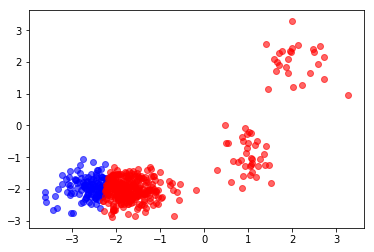

In [36]:
plt.scatter(x_test[n_d<a_d, 0], x_test[n_d<a_d, 1], color="blue", alpha=0.6)
plt.scatter(x_test[n_d>=a_d, 0], x_test[n_d>=a_d, 1], color="red", alpha=0.6)

plt.show()

In [25]:
n_d

array([ 4995.98182278,  5739.52803213,  6134.43607001,  7806.22467682,
        5281.48276346,  4618.59237024,  5278.59936009,  9403.95625368,
        5520.87689001,  5283.81388682,  5121.26479965,  5854.41591499,
        5139.69382866,  4135.77184223,  4383.55614286,  4745.79274949,
        4755.42058781,  5878.82313311,  4933.97346494,  4396.85639142,
        5109.15590879,  5277.42226567,  4792.71186322,  5631.77738441,
        5656.26104271,  7009.50051855,  4211.33240432,  6501.68520714,
        5399.15139874,  4915.54931535,  5379.40113318,  6424.161423  ,
        4354.13019478,  6045.61760283,  5323.65535968,  4722.14583862,
        5239.94880233,  6676.95999109,  5388.14943847,  4733.24077839,
        4013.47802661,  5021.56275968,  5465.14537605,  5033.72842929,
        4884.4292666 ,  5141.12097446,  5120.10280496,  4528.26222919,
        7666.2591417 ,  5453.95389407,  4640.32343008,  4289.49949385,
        5579.96218891,  4849.05642151,  4959.10049825,  4768.54301105,
      

In [27]:
a_d

array([2833.58716469, 3742.57581718, 4631.90094594, 5574.9895899 ,
       2562.38698048, 2912.44302465, 3548.30291994, 4107.13910271,
       3011.96980417, 3630.51058879, 1858.49455673, 3144.33612553,
        188.82228426, 2147.27836902,  359.2644131 , 2934.71715871,
       2575.938341  , 2708.47344453, 3351.20056716, 2832.04781258,
       2944.17258165, 3765.10244186,  473.86719474, 2785.93499425,
       2891.30826811, 3976.63142942, 1991.60023082, 3285.55536889,
       2183.05317015, 3572.78939105, 3368.04109941, 4132.27529362,
       1826.88105047, 3740.45059468, 3105.80810966, 2158.89986686,
       3264.44840279, 4665.39752771, 1517.16222144, 1727.06099583,
       1955.80245894, 3173.39889183, 3861.41470837, 2738.10805684,
       2011.46274802, 3013.94397732, 3626.52468267, 2786.28765183,
       6414.03727112, 2873.66257718, 2280.33181386, 2408.82918231,
       2067.06767602, 2672.19492994,  172.22334853, 3029.39552936,
       3758.18001827, 2021.26621789, 4002.96881197, 3132.11737

In [29]:
np.where(y_train==0)[0]

array([350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362,
       363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375,
       376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388,
       389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401,
       402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414,
       415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427,
       428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440,
       441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453,
       454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466,
       467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479,
       480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492,
       493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505,
       506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518,
       519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 53